# Denoising Autoencoder

Autoencoder (AE) is a neural network which is trained to copy its input to its output. It has two components:
1. Encoder, which represents the input as code
2. Decoder, which produces a reconstruction of the input from its code

AE is trained such that it is able to extract important properties of data. So, it does not have to copy the input to output perfectly. One way to train AE is by feeding corrupted input and force it to reconstruct the original input. This is called denoising autoencoder (DAE). This method avoids AE from learning a trivial identity function, i.e. not learning anything useful.

In this notebook, we train a DAE on MNIST dataset. We try out some different architectures, compare their accuracy, and visualize the code (the output of the encoder's highest layer).

# Import Libraries

In [ ]:
import numpy as np
import seaborn as sns

from joblib import dump, load
from keras import layers, utils
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Load MNIST Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, shuffle= True, random_state=0)

# Scale data from [0,255] to [0,1] so we can work as if it's a binary output
x_train = x_train.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape each image from matrix to vector
x_train = x_train.reshape((len(x_train), 28*28))
x_valid = x_valid.reshape((len(x_valid), 28*28))
x_test = x_test.reshape((len(x_test), 28*28))

# Change label to one-hot encoding (will be used later for digit classifier)
y_train_cat = to_categorical(y_train, 10)
y_valid_cat = to_categorical(y_valid, 10)
y_test_cat = to_categorical(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


# Functions

## Utils

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
def add_noise(data, noise_factor, scale=1.0):
    data_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return data_noisy
    #return np.clip(data_noisy, 0., 1.) # make sure the values are still in range [0,1]

In [ ]:
def display_test_set(autoencoder, test_set, num_img, display_ori=True, start_idx=0):
    decoded_imgs = autoencoder(test_set)
    plt.figure(figsize=(20, 4))
    for i in range(num_img):
        # Display original
        if (display_ori):
            ax = plt.subplot(2, num_img, i + 1)
            if (len(test_set[i].shape) == 2):
                plt.imshow(test_set[i+start_idx])
            else:
                plt.imshow(test_set[i+start_idx].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, num_img, i + 1 + num_img)
        decoded_img = decoded_imgs[i+start_idx].numpy()
        if (len(decoded_img.shape) == 2):
            plt.imshow(decoded_img)
        else:
            plt.imshow(decoded_img.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
def get_tsne_encoding(autoencoder, X):
    encoder = get_encoder(autoencoder)
    encodings = encoder(X).numpy()
    tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=40, n_iter=300)
    return tsne.fit_transform(encodings)

In [ ]:
def plot_tsne_encoding(autoencoder, X, Y):
    encodings = get_tsne_encoding(autoencoder, X)
    sns.scatterplot(
        x=encodings[:,0],
        y=encodings[:,1],
        hue=Y,
        palette=sns.color_palette("hls", 10),
        legend="full",
        alpha=0.3
    )

## Build and Train Model

In [ ]:
def train_denoise_autoenc(autoencoder, epochs, noise_factor=0.3):
    for i in range(epochs):
        x_train_noisy = add_noise(x_train, noise_factor)
        x_valid_noisy = add_noise(x_valid, noise_factor)

        print("Epoch {}/{}".format(i+1, epochs))
        autoencoder.fit(x_train_noisy, x_train,
                        epochs=1,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_valid_noisy, x_valid))

In [ ]:
def train_new_layer(encoder, model, epochs, noise_factor=0.3):
    for i in range(epochs):
        x_train_noisy = add_noise(x_train, noise_factor)
        x_valid_noisy = add_noise(x_valid, noise_factor)

        print("Epoch {}/{}".format(i+1, epochs))

        encoded_input = encoder(x_train_noisy)
        encoded_valid = encoder(x_valid_noisy)
        model.fit(encoded_input, encoded_input,
                  epochs=1,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(encoded_valid, encoded_valid))

In [ ]:
def get_single_layer_autoencoder(encoding_dim, epochs=20, noise_factor=0.3):
    # 784 --> encoding_dim --> 784
    autoencoder = Sequential()
    autoencoder.add(layers.Dense(encoding_dim, activation='sigmoid', input_shape=(28*28,)))
    autoencoder.add(layers.Dense(28*28, activation='sigmoid'))
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanSquaredError()])
    train_denoise_autoenc(autoencoder, epochs, noise_factor)
    return autoencoder

In [ ]:
def get_deep_autoencoder(encoding_dims, epochs=50, noise_factor=0.3):
    base_model = get_single_layer_autoencoder(encoding_dims[0], epochs)
    output_layers = list()

    # Remove output layer and keep it
    output_layers.append(base_model.layers[-1])
    base_model.pop()

    for i in range(1, len(encoding_dims)):
        # Build another autoencoder
        new_autoenc = Sequential()
        new_autoenc.add(layers.Dense(encoding_dims[i], activation='sigmoid', input_shape=(encoding_dims[i-1],)))
        new_autoenc.add(layers.Dense(encoding_dims[i-1], activation='sigmoid'))
        new_autoenc.compile(optimizer='adam', loss='mse')

        # Train the new autoencoder
        print("\nTraining layer: ", i+1)
        train_new_layer(base_model, new_autoenc, epochs, noise_factor)

        # Add the new encoder
        base_model.add(new_autoenc.layers[0])

        # Keep the output layer
        output_layers.append(new_autoenc.layers[-1])

    # Add all output layers
    for i in range(len(output_layers)-1,-1,-1):
        base_model.add(output_layers[i])

    return base_model

In [ ]:
def get_encoder(autoencoder):
    encoder = Sequential()
    n_layers = len(autoencoder.layers)//2
    for i in range(n_layers):
        encoder.add(autoencoder.layers[i])
    return encoder

In [ ]:
def build_classifier(autoencoder, epochs=50):
    classifier = get_encoder(autoencoder)

    # Set all encoder layers to not trainable
    for i in range(len(classifier.layers)):
        classifier.layers[i].trainable = False

    # Add the output layer
    classifier.add(layers.Dense(10, activation='softmax'))

    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    classifier.fit(x_train, y_train_cat,
                   epochs=epochs,
                   batch_size=256,
                   shuffle=True,
                   validation_data=(x_valid, y_valid_cat))

    return classifier

# Single Layer Autoencoder
We start by training several AE with one hidden layer.


In [ ]:
x_test_noisy = add_noise(x_test, 0.3)

In [ ]:
# Build several single layer autoencoders with different number of hidden neurons
single_layer_256 = get_single_layer_autoencoder(256)
single_layer_128 = get_single_layer_autoencoder(128)
single_layer_64 = get_single_layer_autoencoder(64)
single_layer_32 = get_single_layer_autoencoder(32)

In [ ]:
# Check the loss on test set
single_layer_256.evaluate(x_test_noisy, x_test)
single_layer_128.evaluate(x_test_noisy, x_test)
single_layer_64.evaluate(x_test_noisy, x_test)
single_layer_32.evaluate(x_test_noisy, x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2626 - mean_squared_error: 0.0675


[0.2625950574874878, 0.0674816370010376]

Let's see the image reconstructions of those autoencoders!

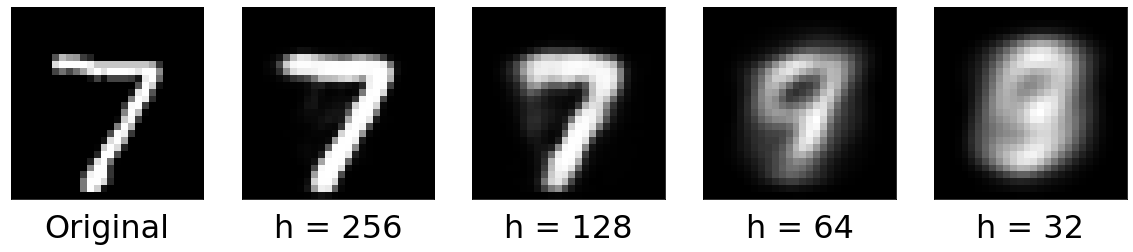

In [ ]:
plt.figure(figsize=(20, 4))
plt.gray()

# Display ori
ax = plt.subplot(1, 5, 1)
plt.imshow(x_test[0].reshape(28,28))
ax.text(0.5,-0.2, "Original", size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_256
decoded_img = single_layer_256(x_test[0:1])[0].numpy()
ax = plt.subplot(1, 5, 2)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "h = 256", size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_128
decoded_img = single_layer_128(x_test[0:1])[0].numpy()
ax = plt.subplot(1, 5, 3)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "h = 128", size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_64
decoded_img = single_layer_64(x_test[0:1])[0].numpy()
ax = plt.subplot(1, 5, 4)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "h = 64", size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_32
decoded_img = single_layer_32(x_test[0:1])[0].numpy()
ax = plt.subplot(1, 5, 5)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "h = 32", size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

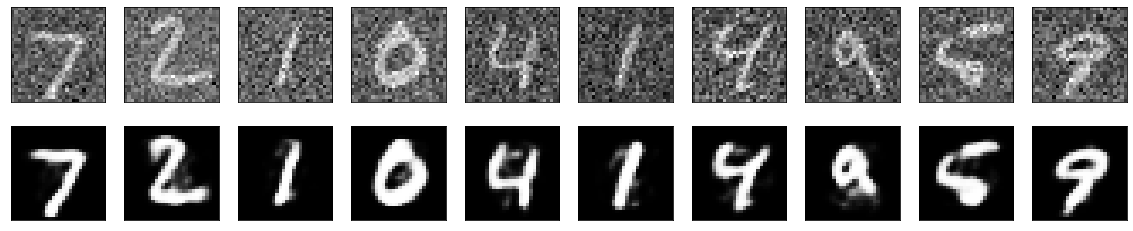

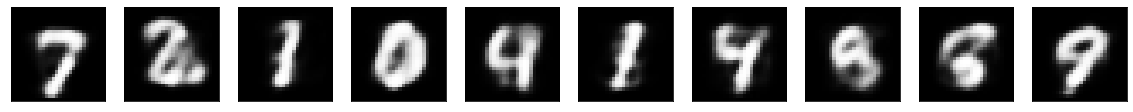

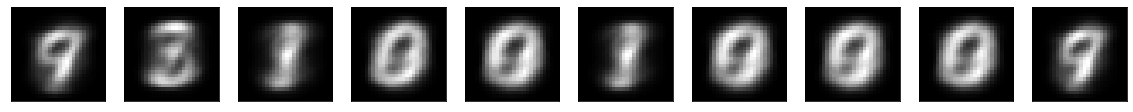

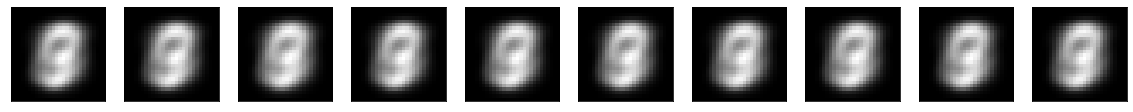

In [ ]:
display_test_set(single_layer_256, x_test_noisy, 10)
display_test_set(single_layer_128, x_test_noisy, 10, False)
display_test_set(single_layer_64, x_test_noisy, 10, False)
display_test_set(single_layer_32, x_test_noisy, 10, False)

As the number of hidden neurons decreases, the image reconstructions become more blur. It means that the model is no longer having enough capacity to capture salient features of the data.

In practice, we are not interested with AE's output. Let's try to use it for digit classification. We will only get the encoder part, use it to map the input to its code, then classify the code.

In [ ]:
# Train a digit classifier. The input of the classifier is the digit encodings (encoder's output).
classifier_single_layer_256 = build_classifier(single_layer_256)
classifier_single_layer_128 = build_classifier(single_layer_128)
classifier_single_layer_64 = build_classifier(single_layer_64)
classifier_single_layer_32 = build_classifier(single_layer_32)

In [ ]:
# Check accuracy on the test set
classifier_single_layer_256.evaluate(x_test, y_test_cat)
classifier_single_layer_128.evaluate(x_test, y_test_cat)
classifier_single_layer_64.evaluate(x_test, y_test_cat)
classifier_single_layer_32.evaluate(x_test, y_test_cat)

313/313 [==============================] - 0s 2ms/step - loss: 2.2964 - accuracy: 0.1135


[2.296445608139038, 0.11349999904632568]

As the number of hidden neurons decreases, the MSE of the image reconstruction increases and the accuracy of the digit classifier decreases.

# Deep Autoencoder
Single layer AE with **h** = 32 does not work well. What if we want to represent our 784-dimensional data in 32 dimension? Use multiple layers!

We can train deep AE with the usual backpropagation (AE is a fully-connected feedforward NN after all). However, it's better to use unsupervised layerwise pretraining.

We build several deep AEs with different configurations.

In [ ]:
# Build several deep AE with 32 neurons in the highest layer
deep_2 = get_deep_autoencoder([256, 32])
deep_3 = get_deep_autoencoder([256, 128, 32])
deep_4 = get_deep_autoencoder([256, 128, 64, 32])
deep_5 = get_deep_autoencoder([400, 225, 100, 32])
deep_6 = get_deep_autoencoder([256, 128, 64, 32, 16, 8])

In [ ]:
# Check the MSE on test set
deep_2.evaluate(x_test_noisy, x_test)
deep_3.evaluate(x_test_noisy, x_test)
deep_4.evaluate(x_test_noisy, x_test)
deep_5.evaluate(x_test_noisy, x_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0850 - mean_squared_error: 0.0073


[0.08502957224845886, 0.007313683163374662]

Just like before, we also build classifiers with the encoders.

In [ ]:
# Train a digit classifier. The input of the classifier is the digit encodings (encoder's output).
classifier_deep_2 = build_classifier(deep_2)
classifier_deep_3 = build_classifier(deep_3)
classifier_deep_4 = build_classifier(deep_4)
classifier_deep_5 = build_classifier(deep_5)

In [ ]:
# Check accuracy on the test set
classifier_deep_2.evaluate(x_test, y_test_cat)
classifier_deep_3.evaluate(x_test, y_test_cat)
classifier_deep_4.evaluate(x_test, y_test_cat)
classifier_deep_5.evaluate(x_test, y_test_cat)

313/313 [==============================] - 1s 3ms/step - loss: 0.4741 - accuracy: 0.8656


[0.47409048676490784, 0.8655999898910522]

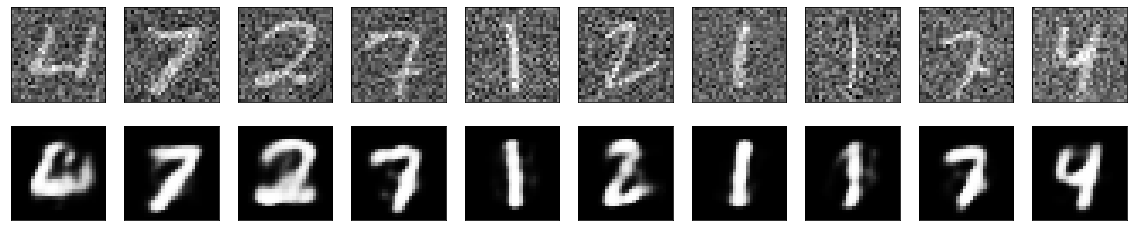

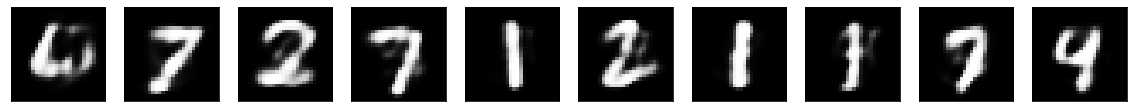

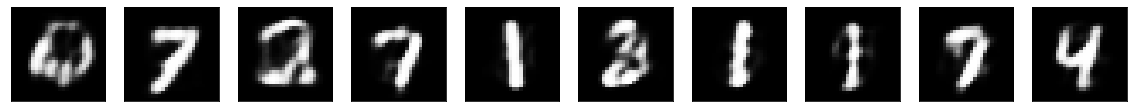

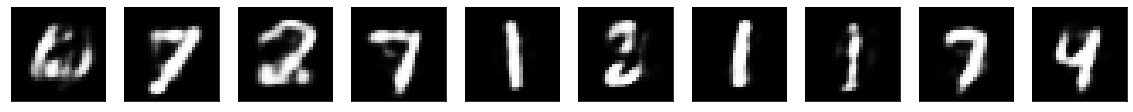

In [ ]:
display_test_set(deep_2, x_test_noisy, 10, start_idx=33)
display_test_set(deep_3, x_test_noisy, 10, False, start_idx=33)
display_test_set(deep_4, x_test_noisy, 10, False, start_idx=33)
display_test_set(deep_5, x_test_noisy, 10, False, start_idx=33)

We can encode 784 dimensional data in 32 dimensions by using multiple encoder layers! The performance varies according to the number of layers and number of neurons per layer. Note that the best model at image reconstruction is not the best at digit classification.

This is to check which images the classifiers fail to identify

In [ ]:
deep_2_pred = classifier_deep_2.predict_classes(x_test)
deep_3_pred = classifier_deep_3.predict_classes(x_test)
deep_4_pred = classifier_deep_4.predict_classes(x_test)
deep_5_pred = classifier_deep_5.predict_classes(x_test)

print((np.where(y_test!=deep_2_pred)[0])[0:20]) # index of first 10 images which are failed to be identified
print((np.where(y_test!=deep_3_pred)[0])[0:20])
print((np.where(y_test!=deep_4_pred)[0])[0:20])
print((np.where(y_test!=deep_5_pred)[0])[0:20])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[  8  33  38  46  54  62  65  66  73  77  97 111 119 124 126 187 193 195
 217 219]
[  8  15  33  46  63  77  80  92  97 111 124 126 133 144 149 151 193 195
 217 219]
[  8  18  33  54  62  65  66  73  77  80  98 111 120 124 126 139 149 151
 152 167]
[  1   8  11  15  18  33  54  63  77  80 104 115 124 149 151 159 171 172
 193 195]


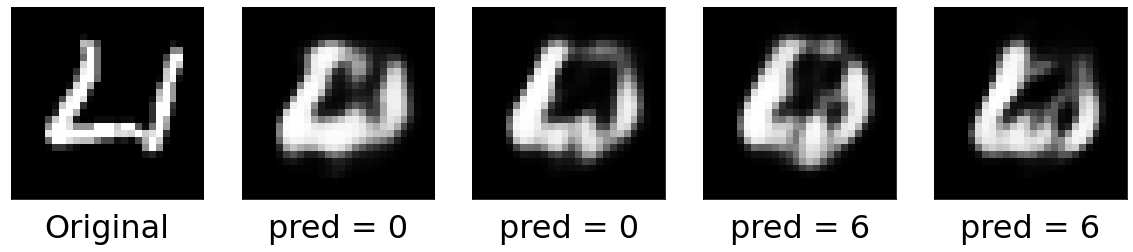

In [ ]:
plt.figure(figsize=(20, 4))
plt.gray()

# Display ori
ax = plt.subplot(1, 5, 1)
plt.imshow(x_test[33].reshape(28,28))
ax.text(0.5,-0.2, "Original", size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_256
decoded_img = deep_2(x_test[33:34])[0].numpy()
ax = plt.subplot(1, 5, 2)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "pred = {}".format(deep_2_pred[33]), size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_128
decoded_img = deep_3(x_test[33:34])[0].numpy()
ax = plt.subplot(1, 5, 3)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "pred = {}".format(deep_3_pred[33]), size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_64
decoded_img = deep_4(x_test[33:34])[0].numpy()
ax = plt.subplot(1, 5, 4)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "pred = {}".format(deep_4_pred[33]), size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# single_layer_32
decoded_img = deep_5(x_test[33:34])[0].numpy()
ax = plt.subplot(1, 5, 5)
plt.imshow(decoded_img.reshape(28,28))
ax.text(0.5,-0.2, "pred = {}".format(deep_5_pred[33]), size=32, ha="center", transform=ax.transAxes)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

# Deep Autoencoder with Fine Tuning

In [ ]:
ft_deep_2 = get_deep_autoencoder([256, 32])
ft_deep_3 = get_deep_autoencoder([256, 128, 32])
ft_deep_4 = get_deep_autoencoder([256, 128, 64, 32])
ft_deep_5 = get_deep_autoencoder([400, 225, 100, 32])

# Fine tune
train_denoise_autoenc(ft_deep_2, epochs=10, noise_factor=0.3)
train_denoise_autoenc(ft_deep_3, epochs=10, noise_factor=0.3)
train_denoise_autoenc(ft_deep_4, epochs=10, noise_factor=0.3)
train_denoise_autoenc(ft_deep_5, epochs=10, noise_factor=0.3)

In [ ]:
# Check the MSE on test set
ft_deep_2.evaluate(x_test_noisy, x_test)
ft_deep_3.evaluate(x_test_noisy, x_test)
ft_deep_4.evaluate(x_test_noisy, x_test)
ft_deep_5.evaluate(x_test_noisy, x_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0837 - mean_squared_error: 0.0070


[0.08371486514806747, 0.006950479932129383]

In [ ]:
# Train a digit classifier. The input of the classifier is the digit encodings (encoder's output).
classifier_ft_deep_2 = build_classifier(ft_deep_2)
classifier_ft_deep_3 = build_classifier(ft_deep_3)
classifier_ft_deep_4 = build_classifier(ft_deep_4)
classifier_ft_deep_5 = build_classifier(ft_deep_5)

In [ ]:
# Check accuracy on the test set
classifier_ft_deep_2.evaluate(x_test, y_test_cat)
classifier_ft_deep_3.evaluate(x_test, y_test_cat)
classifier_ft_deep_4.evaluate(x_test, y_test_cat)
classifier_ft_deep_5.evaluate(x_test, y_test_cat)

313/313 [==============================] - 1s 3ms/step - loss: 0.4761 - accuracy: 0.8660


[0.4760624170303345, 0.8659999966621399]

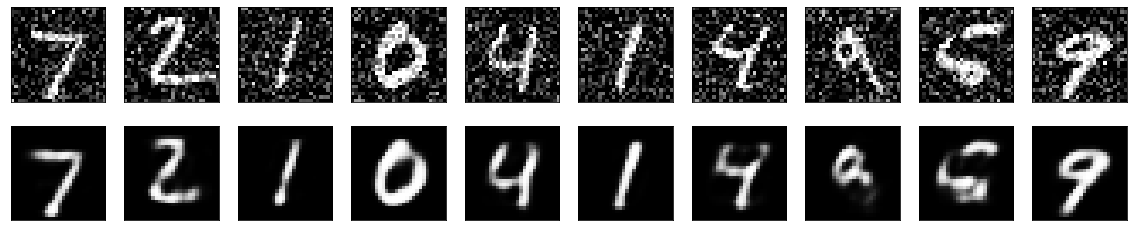

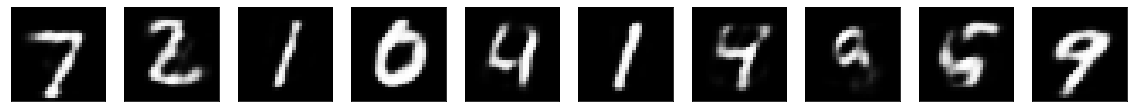

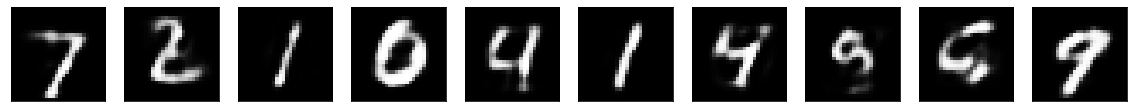

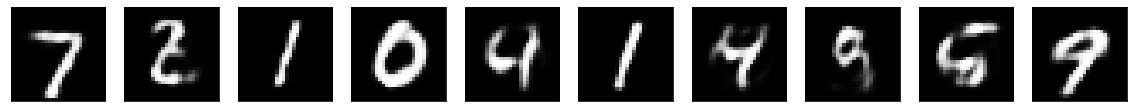

In [ ]:
display_test_set(ft_deep_2, x_test_noisy, 10)
display_test_set(ft_deep_3, x_test_noisy, 10, False)
display_test_set(ft_deep_4, x_test_noisy, 10, False)
display_test_set(ft_deep_5, x_test_noisy, 10, False)

We can see that fine tuning improves the performance.

# Visualization of Encodings
First, let's try to visualize the MNIST dataset. Since the data is too large, we will just get a subset of it (1000 images per digit).

In [ ]:
# Get subset of data
img_per_class = 1000
x_subset = []
y_subset = []
for i in range(10):
    indexes = np.where(y_train == i)[0][0:img_per_class]
    x_subset.append(x_train[indexes])
    y_subset.append(y_train[indexes])
x_subset = np.concatenate(x_subset, axis=0)
y_subset = np.concatenate(y_subset, axis=0)

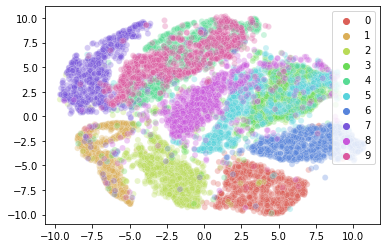

In [ ]:
# Project to 2D
tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=40, n_iter=300)
x_low_dim = tsne.fit_transform(x_subset)

# Plot
sns.scatterplot(x=x_low_dim[:,0], y=x_low_dim[:,1], hue=y_subset, 
                palette=sns.color_palette("hls", 10), legend="full", alpha=0.3)

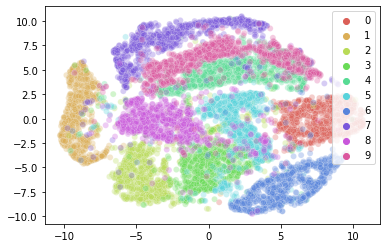

In [ ]:
plot_tsne_encoding(single_layer_128, x_subset, y_subset)

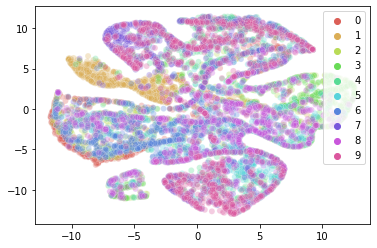

In [ ]:
plot_tsne_encoding(single_layer_64, x_subset, y_subset)

The encodings of single layer with **h** = 64 is not well separated. That's why the accuracy is poor.

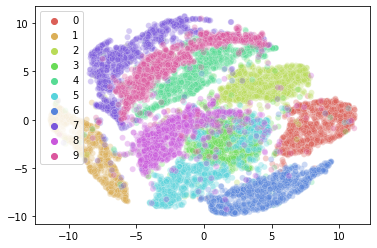

In [ ]:
plot_tsne_encoding(deep_2, x_subset, y_subset)

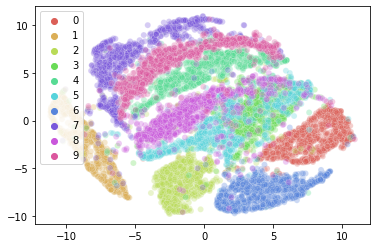

In [ ]:
plot_tsne_encoding(ft_deep_2, x_subset, y_subset)

There's not much differences between the visualization of DAE with and without fine tuning.

## A Closer Look to t-SNE
Now, let's zoom to the encodings of digit 1. We have highlighted 7 data points in the dense area.

In [ ]:
# Use ft_deep_2 model
encodings = get_tsne_encoding(ft_deep_2, x_subset)

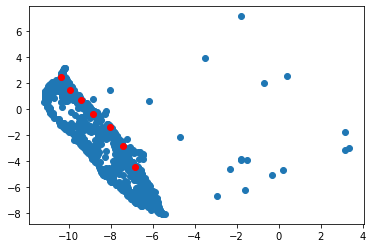

In [ ]:
# Plot only digits of 1
idx_of_1 = np.arange(start=1000, stop=2000)
plt.scatter(encodings[idx_of_1,0], encodings[idx_of_1,1], alpha=1)

# Highlight some data points
highlight_idxs = [1077, 1079, 1186, 1049, 1050, 1016, 1707]
plt.scatter(encodings[highlight_idxs,0], encodings[highlight_idxs,1], alpha=1, color="red")

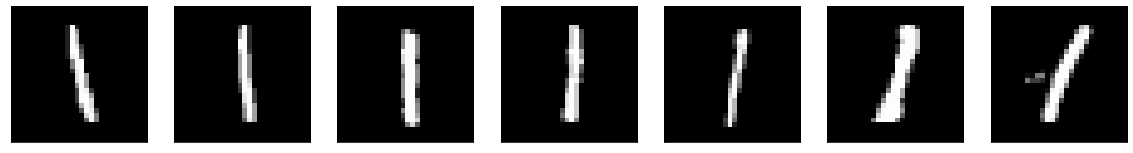

In [ ]:
# Let's see that images
plt.figure(figsize=(20, 4))
for i, idx in enumerate(highlight_idxs):
    ax = plt.subplot(1, len(highlight_idxs), i + 1)
    plt.imshow(x_subset[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

As you move from the top left to the bottom right, the images of 1 are gradually rotated clockwise. What about other points scattered far away?

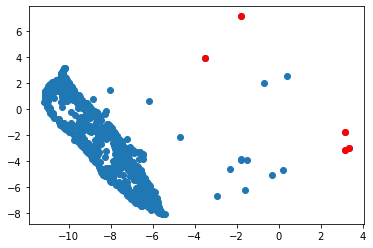

In [ ]:
plt.scatter(encodings[idx_of_1,0], encodings[idx_of_1,1], alpha=1)
highlight_idxs = [1596, 1369, 1027, 1100, 1778]
plt.scatter(encodings[highlight_idxs,0], encodings[highlight_idxs,1], alpha=1, color="red")

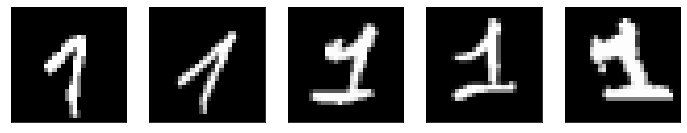

In [ ]:
# Let's see that images
plt.figure(figsize=(12, 4))
for i, idx in enumerate(highlight_idxs):
    ax = plt.subplot(1, len(highlight_idxs), i + 1)
    plt.imshow(x_subset[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Those points have a different shape of 1 (not just a straight line).

# Random Input
Let's try to increase the noise and see if the AE can reconstruct it.

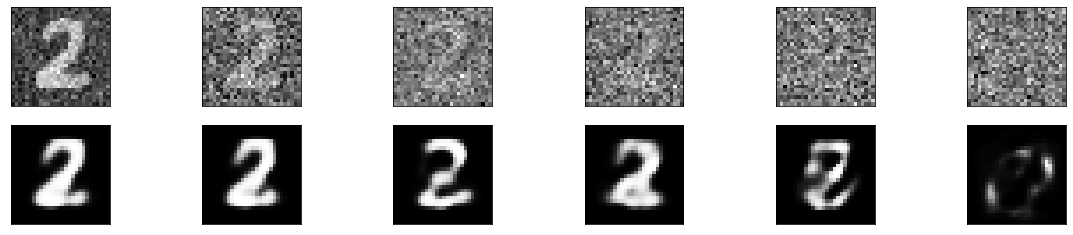

In [ ]:
new_noisy_set = []
sample_img = x_train[28]
noise = range(1,11,2)
for n in noise:
    noisy_img = add_noise(sample_img, noise_factor=n*0.2)
    new_noisy_set.append(noisy_img)
random_img = np.random.normal(loc=1, scale=1, size=(28*28,))
new_noisy_set.append(random_img)
new_noisy_set = np.concatenate(new_noisy_set, axis=0)
new_noisy_set = new_noisy_set.reshape(6, 784)

display_test_set(deep_2, new_noisy_set, 6, display_ori=True)

As the noise increases, the reconstructed image becomes more unclear, but still converging to the manifold. In fact, even when the input is a random image, the result is still converging to the manifold.